<h1 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h1>

<h2 style="text-align: center;"><b>Семестр 1 Осень 2025 года. Финальный проект. Geometry ML</b></h2>


**Выполил:** Емельянов Евгений  
**Stepik ID:** https://stepik.org/users/37851967  
**TG:** evg_em

<h2 style="text-align: center;"><b>Часть 3. Решение задачи классификации графов с помощью Graph Neural Network</b></h2>

## Загрузка библиотек

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import pickle
warnings.filterwarnings('ignore')

## Как частный случай графовых equivariant моделей будет использована GAT

In [2]:
def split_ego_networks(ego_ids, train_ratio=0.7, val_ratio=0.15, random_state=42):
    np.random.seed(random_state)
    shuffled_ids = np.random.permutation(ego_ids)
    
    n_train = int(len(shuffled_ids) * train_ratio)
    n_val = int(len(shuffled_ids) * val_ratio)
    
    train_ids = shuffled_ids[:n_train]
    val_ids = shuffled_ids[n_train:n_train + n_val]
    test_ids = shuffled_ids[n_train + n_val:]

    return train_ids, val_ids, test_ids

GAT for multi-label classification
https://arxiv.org/pdf/1710.10903

In [3]:
class GATMultiLabel(nn.Module):
    def __init__(self, num_features, hidden_dim, max_classes, heads, dropout):
        super().__init__()
        self.conv1 = GATConv(num_features, hidden_dim, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, dropout=dropout, concat=False)
        self.lin = nn.Linear(hidden_dim, max_classes)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin(x)
        return torch.sigmoid(x)

## Prepare Data

In [4]:
EMBEDDING_DIM = 64
HIDDEN_DIM = 128
HEADS = 4
DROPOUT = 0.3
EPOCHS = 200
LEARNING_RATE = 0.01
WEIGHT_DECAY = 5e-4
PATIENCE = 20
THRESHOLD = 0.5

results = {
    'baseline': {'metrics': {}, 'model': None, 'history': {}, 'pca_model': None},
    'enriched': {'metrics': {}, 'model': None, 'history': {}}
}

In [5]:
def prepare_pca_embeddings(enriched_ego_network, embedding_dim=EMBEDDING_DIM):

    all_raw_features = []
    
    for ego_id, data in enriched_ego_network.items():
        if 'node_features_raw' in data and data['node_features_raw'] is not None:
            features = data['node_features_raw']
            all_raw_features.append(features)

    
    max_dim = max(f.shape[1] for f in all_raw_features)

    features_padded = []
    for features in all_raw_features:
        if features.shape[1] < max_dim:
            padded = np.pad(features, ((0, 0), (0, max_dim - features.shape[1])), mode='constant', constant_values=0)
            features_padded.append(padded)
        else:
            features_padded.append(features)
    
    X_all = np.vstack(features_padded)
    
    pca = PCA(n_components=embedding_dim)
    X_pca = pca.fit_transform(X_all)
    
    start_idx = 0
    pca_embeddings = {}
    
    for ego_id, data in enriched_ego_network.items():
        if 'node_features_raw' in data and data['node_features_raw'] is not None:
            n_nodes = data['node_features_raw'].shape[0]
            pca_embeddings[ego_id] = X_pca[start_idx:start_idx + n_nodes]
            start_idx += n_nodes
    
    return pca_embeddings, pca

In [6]:
def create_labels(enriched_ego_network):

    label_matrices = {}
    label_info = {}
    
    for ego_id, data in enriched_ego_network.items():
        circles = data.get('circles', {})
        if not circles:
            continue
        
        if 'node_ids' in data:
            node_ids = data['node_ids']
        else:
            node_ids = list(data['graph'].nodes())
        
        node_to_idx = {node: idx for idx, node in enumerate(node_ids)}
        circle_names = list(circles.keys())
        circle_to_idx = {name: idx for idx, name in enumerate(circle_names)}
        
        Y = np.zeros((len(node_ids), len(circle_names)), dtype=np.float32)
        
        for circle_name, members in circles.items():
            circle_idx = circle_to_idx[circle_name]
            for member in members:
                if member in node_to_idx:
                    Y[node_to_idx[member], circle_idx] = 1.0
        
        label_matrices[ego_id] = Y
        label_info[ego_id] = {
            'circle_names': circle_names,
            'num_circles': len(circle_names),
            'node_ids': node_ids
        }
    
    return label_matrices, label_info

In [7]:
def create_feature_matrices(enriched_ego_network, pca_embeddings, mode='baseline'):
    feature_matrices = {}
    
    for ego_id, data in enriched_ego_network.items():
        
        pca_base = pca_embeddings[ego_id]
        n_nodes_full = pca_base.shape[0]
        
        if mode == 'baseline':
            X = pca_base
            
        else:
            components = [pca_base]            
            feature_types = ['structural_features', 'global_features', 'local_features']
            # semantic_features не добавил, т.к. они уже в каккой-то степени содержаться в PCA-embedding'ах
            for feat_type in feature_types:
                if feat_type in data:
                    features = data[feat_type]
                    
                    if features.shape[0] < n_nodes_full:
                        n_features = features.shape[1]
                        padded_features = np.zeros((n_nodes_full, n_features), dtype=np.float64)
                        padded_features[:features.shape[0], :] = features                        
                        components.append(padded_features)
                    else:
                        components.append(features)
            
            try:
                X = np.hstack(components)
            except ValueError as e:
                print(f"Ошибка при объединении признаков для ego {ego_id}: {e}")
                X = pca_base
                
        feature_matrices[ego_id] = X  
        
    return feature_matrices

In [8]:
def prepare_pyg_data(feature_matrices, label_matrices, enriched_ego_network, ego_ids):
    data_dict = {}
    
    max_classes = 0
    for ego_id in ego_ids:
        if ego_id in label_matrices:
            max_classes = max(max_classes, label_matrices[ego_id].shape[1])
      
    for ego_id in ego_ids:
        if ego_id not in feature_matrices or ego_id not in label_matrices:
            continue
        
        X = feature_matrices[ego_id]
        Y = label_matrices[ego_id]
        
        if Y.shape[1] < max_classes:
            Y_padded = np.pad(Y, ((0, 0), (0, max_classes - Y.shape[1])), mode='constant', constant_values=0)
        else:
            Y_padded = Y
        
        G = enriched_ego_network[ego_id]['graph']
        node_list = list(G.nodes())
        node_to_idx = {node: idx for idx, node in enumerate(node_list)}
        
        edge_index = []
        for u, v in G.edges():
            edge_index.append([node_to_idx[u], node_to_idx[v]])
        
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        
        scaler = StandardScaler()
        X_normalized = scaler.fit_transform(X)
        
        data_dict[ego_id] = {
            'x': torch.tensor(X_normalized, dtype=torch.float),
            'y': torch.tensor(Y_padded, dtype=torch.float),
            'edge_index': edge_index,
            'num_nodes': X.shape[0],
            'num_features': X.shape[1],
            'num_classes': Y.shape[1],
            'max_classes': max_classes,
            'original_y_shape': Y.shape,
            'scaler': scaler
        }
    
    return data_dict

## Train&Evalute Model

In [9]:
def train_model(model, data_dict, train_ids, val_ids, epochs=EPOCHS, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, patience=PATIENCE):
   
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCELoss()
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    train_history = {'loss': [], 'val_loss': []}
    
    print(f"\nОбучение модели")
    for epoch in tqdm(range(epochs)):
        model.train()
        total_loss = 0
        total_batches = 0
        
        for ego_id in train_ids:
            if ego_id not in data_dict:
                continue
            
            data = data_dict[ego_id]
            optimizer.zero_grad()
            
            out = model(data['x'], data['edge_index'])
            loss = criterion(out, data['y'])
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            total_batches += 1
        
        avg_train_loss = total_loss / total_batches if total_batches > 0 else 0
        
        model.eval()
        val_loss = 0
        val_batches = 0
        
        with torch.no_grad():
            for ego_id in val_ids:
                if ego_id not in data_dict:
                    continue
                
                data = data_dict[ego_id]
                out = model(data['x'], data['edge_index'])
                loss = criterion(out, data['y'])
                val_loss += loss.item()
                val_batches += 1
        
        avg_val_loss = val_loss / val_batches if val_batches > 0 else 0
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        train_history['loss'].append(avg_train_loss)
        train_history['val_loss'].append(avg_val_loss)
        
        if patience_counter >= patience:
            print(f"Early stopping на эпохе {epoch}")
            break
    
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model, train_history

### Метрики
Для оценки используется F1-score как оптимальный вариант для несбалансированных данных.  
В частности **micro-F1** как глобальная мера (насколько хорошо модель в целом определяет принадлежность к кругам) и **macro-F1** которая усредняет F1 по каждому кругу (насколько хорошо модель работает с редкими классами)

In [10]:
def evaluate_model(model, data_dict, test_ids, threshold=THRESHOLD):
    
    model.eval()
    all_metrics = []
    
    with torch.no_grad():
        for ego_id in test_ids:
            if ego_id not in data_dict:
                continue
            
            data = data_dict[ego_id]
            pred = model(data['x'], data['edge_index'])
            
            best_f1 = 0
            best_threshold = threshold
            
            for th in [0.1, 0.2, 0.3, 0.4, 0.5]:
                pred_binary = (pred > th).float()
                num_real_classes = data['num_classes']
                pred_cropped = pred_binary[:, :num_real_classes]
                labels_cropped = data['y'][:, :num_real_classes]
                
                try:
                    f1 = f1_score(labels_cropped.cpu().numpy(), pred_cropped.cpu().numpy(), average='micro', zero_division=0)                    
                    if f1 > best_f1:
                        best_f1 = f1
                        best_threshold = th
                    
                except:
                    continue

            print(f"\n  Для Ego {ego_id}:")
            print(f"    Min prediction: {pred.min().item():.4f}")
            print(f"    Max prediction: {pred.max().item():.4f}")
            print(f"    Mean prediction: {pred.mean().item():.4f}")
            print(f"    Predictions > 0.5: {(pred > 0.5).sum().item()}")
            print(f"    Лучший порог: {best_threshold}, F1: {best_f1:.4f}")
            pred_binary = (pred > best_threshold).float()
            num_real_classes = data['num_classes']
            pred_cropped = pred_binary[:, :num_real_classes]
            labels_cropped = data['y'][:, :num_real_classes]
            
            predictions = pred_cropped.cpu().numpy()
            labels = labels_cropped.cpu().numpy()
            
            try:
                metrics = {
                    'micro_f1': f1_score(labels, predictions, average='micro', zero_division=0),
                    'macro_f1': f1_score(labels, predictions, average='macro', zero_division=0),
                    # используется micro -> глобальные предсказания, а не средние ибо в соцсетях круги несбаланироавны, 
                    # а меня интересует "какой % всех предсказаний по ВСЕМ узлам верен?"
                    'precision': precision_score(labels, predictions, average='micro', zero_division=0),
                    'recall': recall_score(labels, predictions, average='micro', zero_division=0),
                    'samples': len(predictions),
                    'ego_id': ego_id,
                    'best_threshold': best_threshold
                }
                all_metrics.append(metrics)
                
            except Exception as e:
                print(f"Ошибка при вычислении метрик для ego {ego_id}: {e}")
    
    if not all_metrics:
        return {}
    
    avg_metrics = {
        'micro_f1': np.mean([m['micro_f1'] for m in all_metrics]),
        'macro_f1': np.mean([m['macro_f1'] for m in all_metrics]),
        'precision': np.mean([m['precision'] for m in all_metrics]),
        'recall': np.mean([m['recall'] for m in all_metrics]),
        'total_samples': sum(m['samples'] for m in all_metrics)
    }
    
    return avg_metrics

## Run Experiments

In [11]:
def run_baseline_experiment(enriched_ego_network, train_ids, val_ids, test_ids, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM,
                            heads=HEADS, dropout=DROPOUT):

    print("-" * 70)
    print("Experiment 1: Baseline")
    
    # PCA embeddings
    pca_embeddings, pca_model = prepare_pca_embeddings(enriched_ego_network, embedding_dim)
    
    label_matrices, label_info = create_labels(enriched_ego_network)

    baseline_features = create_feature_matrices(enriched_ego_network, pca_embeddings, mode='baseline')

    ego_ids = list(enriched_ego_network.keys())
    max_classes = 0
    for ego_id in ego_ids:
        if ego_id in label_matrices:
            max_classes = max(max_classes, label_matrices[ego_id].shape[1])
    
    print(f"Максимальное количество кругов: {max_classes}")

    baseline_data = prepare_pyg_data(baseline_features, label_matrices, enriched_ego_network, ego_ids)

    sample_ego = list(baseline_features.keys())[0]
    baseline_dim = baseline_features[sample_ego].shape[1]
    print(f"Размерность признаков: {baseline_dim}")
    
    baseline_model = GATMultiLabel(baseline_dim, hidden_dim, max_classes, heads, dropout)
    
    baseline_model, baseline_history = train_model(baseline_model, baseline_data, train_ids, val_ids)

    #####
    baseline_metrics = evaluate_model(baseline_model, baseline_data, test_ids)
    
    return {
        'model': baseline_model,
        'metrics': baseline_metrics,
        'history': baseline_history,
        'pca_model': pca_model,
        'pca_embeddings': pca_embeddings,
        'data': baseline_data,
        'features': baseline_features,
        'labels': label_matrices,
        'max_classes': max_classes  
    }

def run_enriched_experiment(enriched_ego_network, pca_embeddings, label_matrices, train_ids, val_ids, test_ids, max_classes,
                            hidden_dim=HIDDEN_DIM, heads=HEADS, dropout=DROPOUT):

    print("\n" + "-" * 70)
    print("Experiment 2: Enriched Model")
    
    enriched_features = create_feature_matrices(enriched_ego_network, pca_embeddings, mode='enriched')

    ego_ids = list(enriched_ego_network.keys())
    enriched_data = prepare_pyg_data(enriched_features, label_matrices, enriched_ego_network, ego_ids)

    sample_ego = list(enriched_features.keys())[0]
    enriched_dim = enriched_features[sample_ego].shape[1]
    print(f"Максимальное количество кругов: {max_classes}")
    print(f"Размерность признаков: {enriched_dim}")

    enriched_model = GATMultiLabel(enriched_dim, hidden_dim, max_classes, heads, dropout)
    
    enriched_model, enriched_history = train_model(enriched_model, enriched_data, train_ids, val_ids)
    
    ####
    enriched_metrics = evaluate_model(enriched_model, enriched_data, test_ids)
    
    return {
        'model': enriched_model,
        'metrics': enriched_metrics,
        'history': enriched_history,
        'data': enriched_data,
        'features': enriched_features
    }

In [12]:
def run_full_experiment(enriched_ego_networks, train_ratio=0.7, val_ratio=0.15, random_state=42):

    print("=" * 70)
    print("Run Full Experiment")
    print("=" * 70)
    
    ego_ids = list(enriched_ego_networks.keys())
    train_ids, val_ids, test_ids = split_ego_networks(ego_ids, train_ratio, val_ratio, random_state)    
    
    # Baseline 
    baseline_results = run_baseline_experiment(enriched_ego_networks, train_ids, val_ids, test_ids)
        
    print(f"\nРезультаты Baseline:")
    baseline_metrics = baseline_results['metrics']
    for metric, value in baseline_metrics.items():
        print(f"  {metric}: {value:.4f}")

    
    # для энричед используем посчитанные в бэйзлайне данные
    pca_embeddings = baseline_results['pca_embeddings']
    label_matrices = baseline_results['labels']
    max_classes = baseline_results.get('max_classes', 0) 
    
    # enriched
    enriched_results = run_enriched_experiment(enriched_ego_networks, pca_embeddings, label_matrices, train_ids, val_ids, test_ids, max_classes)

    print(f"\nРезультаты Enriched:")
    enriched_metrics = enriched_results['metrics']
    for metric, value in enriched_metrics.items():
        print(f"  {metric}: {value:.4f}")    

    visualize_results(baseline_results, enriched_results)
    
    
    return baseline_results, enriched_results

## Visio

In [13]:
def visualize_results (baseline_results, enriched_results):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    metrics_to_compare = ['micro_f1', 'macro_f1', 'precision', 'recall']
    baseline_vals = [baseline_results['metrics'].get(m, 0) for m in metrics_to_compare]
    enriched_vals = [enriched_results['metrics'].get(m, 0) for m in metrics_to_compare]
    
    x = np.arange(len(metrics_to_compare))
    width = 0.35
    

    ax = axes[0, 0]
    if 'history' in baseline_results:
        history = baseline_results['history']
        ax.plot(history['loss'], label='Train Loss', alpha=0.8)
        ax.plot(history['val_loss'], label='Val Loss', alpha=0.8)
        ax.set_xlabel('Эпоха')
        ax.set_ylabel('Loss')
        ax.set_title('Кривые обучения: Baseline')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    ax = axes[0, 1]
    if 'history' in enriched_results:
        history = enriched_results['history']
        ax.plot(history['loss'], label='Train Loss', alpha=0.8)
        ax.plot(history['val_loss'], label='Val Loss', alpha=0.8)
        ax.set_xlabel('Эпоха')
        ax.set_ylabel('Loss')
        ax.set_title('Кривые обучения: Enriched')
        ax.legend()
        ax.grid(True, alpha=0.3)
            
    ax = axes[1,0]
    if 'micro_f1' in baseline_results['metrics']:
        baseline_f1 = baseline_results['metrics']['micro_f1']
        enriched_f1 = enriched_results['metrics']['micro_f1']
        improvement = ((enriched_f1 - baseline_f1) / baseline_f1 * 100) if baseline_f1 > 0 else 0
        
        metrics = ['Baseline', 'Enriched']
        values = [baseline_f1, enriched_f1]
        colors = ['blue', 'green']
        
        bars = ax.bar(metrics, values, color=colors, alpha=0.8)
        ax.set_ylabel('Значение')
        ax.set_title(f'Улучшение Micro F1: {improvement:.1f}%')
        ax.grid(True, alpha=0.3)
        
        for bar, val in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height, f'{val:.4f}', ha='center', va='bottom')
    
    ax = axes[1,1]
    ax.axis('tight')
    ax.axis('off')
    
    if 'metrics' in baseline_results and 'metrics' in enriched_results:
        table_data = []
        for metric in ['micro_f1', 'macro_f1', 'precision', 'recall']:
            baseline_val = baseline_results['metrics'].get(metric, 0)
            enriched_val = enriched_results['metrics'].get(metric, 0)
            improvement = ((enriched_val - baseline_val) / baseline_val * 100) if baseline_val > 0 else 0
            
            table_data.append([
                metric,
                f'{baseline_val:.4f}',
                f'{enriched_val:.4f}',
                f'{improvement:+.1f}%'
            ])
        
        table = ax.table(
            cellText=table_data,
            colLabels=['Metric', 'Baseline', 'Enriched', 'Improvement'],
            cellLoc='center',
            loc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 1.5)
    
    plt.tight_layout()
    plt.show()    

    print("\nРезультаты эксперимента\n")
    print(f"{'Metric':<20} {'Baseline':<12} {'Enriched':<12} {'Improvement %':<12}")
    print("-" * 70)
    
    for metric in ['micro_f1', 'macro_f1', 'precision', 'recall']:
        baseline_val = baseline_results['metrics'].get(metric, 0)
        enriched_val = enriched_results['metrics'].get(metric, 0)
        improvement = ((enriched_val - baseline_val) / baseline_val * 100) if baseline_val > 0 else 0
        
        print(f"{metric:<20} {baseline_val:<12.4f} {enriched_val:<12.4f} {improvement:<+12.1f}")
        

# Go

In [14]:
with open('enriched_ego_networks.pkl', 'rb') as f:
    enriched_ego_networks = pickle.load(f)['enriched_ego_networks']

Run Full Experiment
----------------------------------------------------------------------
Experiment 1: Baseline
Максимальное количество кругов: 46
Размерность признаков: 64

Обучение модели


 37%|███▋      | 74/200 [00:15<00:26,  4.74it/s]

Early stopping на эпохе 74

  Для Ego 1912:
    Min prediction: 0.0003
    Max prediction: 0.5431
    Mean prediction: 0.0254
    Predictions > 0.5: 1
    Лучший порог: 0.1, F1: 0.0312

  Для Ego 3980:
    Min prediction: 0.0007
    Max prediction: 0.5779
    Mean prediction: 0.0311
    Predictions > 0.5: 1
    Лучший порог: 0.1, F1: 0.1455

Результаты Baseline:
  micro_f1: 0.0883
  macro_f1: 0.0311
  precision: 0.0556
  recall: 0.2313
  total_samples: 814.0000

----------------------------------------------------------------------
Experiment 2: Enriched Model


Максимальное количество кругов: 46
Размерность признаков: 76

Обучение модели


 39%|███▉      | 78/200 [00:16<00:25,  4.77it/s]

Early stopping на эпохе 78

  Для Ego 1912:
    Min prediction: 0.0003
    Max prediction: 0.5068
    Mean prediction: 0.0297
    Predictions > 0.5: 2
    Лучший порог: 0.2, F1: 0.0547

  Для Ego 3980:
    Min prediction: 0.0009
    Max prediction: 0.5563
    Mean prediction: 0.0377
    Predictions > 0.5: 2
    Лучший порог: 0.1, F1: 0.1463

Результаты Enriched:
  micro_f1: 0.1005
  macro_f1: 0.0380
  precision: 0.0717
  recall: 0.2844
  total_samples: 814.0000


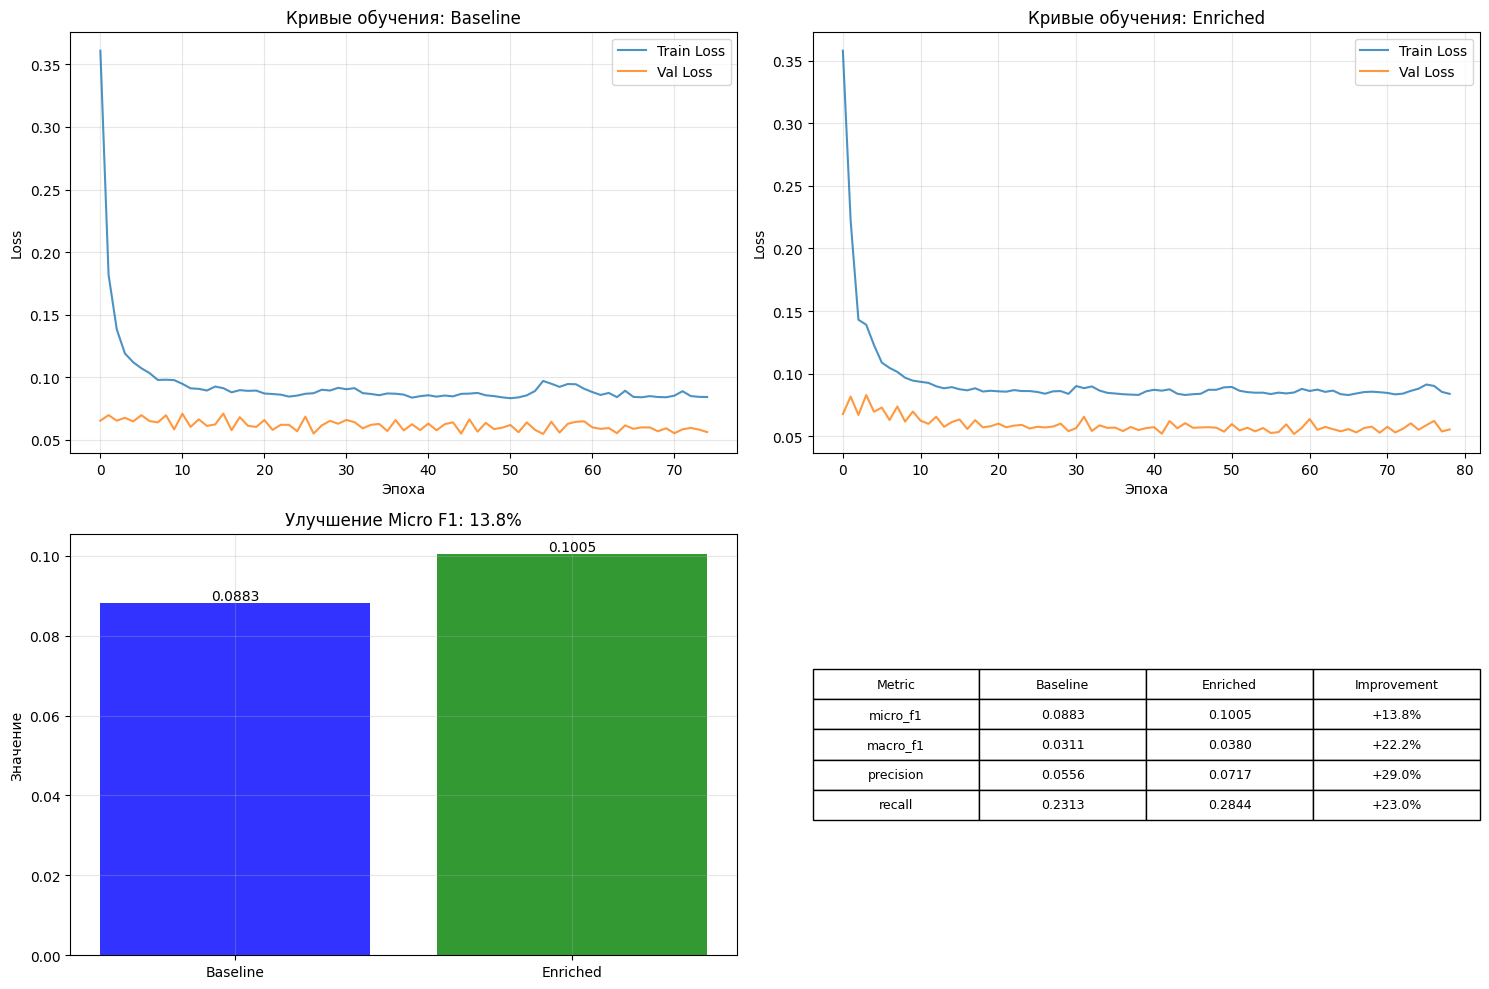


Результаты эксперимента

Metric               Baseline     Enriched     Improvement %
----------------------------------------------------------------------
micro_f1             0.0883       0.1005       +13.8       
macro_f1             0.0311       0.0380       +22.2       
precision            0.0556       0.0717       +29.0       
recall               0.2313       0.2844       +23.0       


In [15]:
baseline_results, enriched_results = run_full_experiment(enriched_ego_networks)

### ВЫВОДЫ О РАБОТЕ GAT ДО И ПОСЛЕ ДОБАВЛНИЯ ТОПОЛОГИЧЕСКИХ ФИЧЕЙ ДЛЯ ОБУЧЕНИЯ :
1. Главный вывод: **TDA-фичи улучшили качество модели**
2. Улучшение ***precision*** (хотя он всё равно низкий) - TDA-признаки помогают модели реже ошибаться при предсказании
3. Улучшение ***recall*** - TDA-признаки помогают модели лучше отличать реальные круги
4. Улучшение ***micro F1*** - TDA-признаки увечили точность предсказаний по всем узлам сети